# Galaxies and the large-scale structure of the Universe, Part II

_A continuation of python exercise notebook written by Rita Tojeiro, October 2017, for the Lab component of the AS1001 Cosmology module at the University of St Andrews, UK.  It was modified to stand alone in an SDSS EPO workshop at AAS in Jan 2018 and then significantly modified to emphasize programming skills rather than Astronomy data analysis by Andrea Lommen, Haverford College, January 2018 and updated by her February 2020. This notebook has benefited from examples provided by Britt Lundgren (University of North Carolina) and Jordan Raddick (John Hopkins University)_.

In this Notebook, you will use data from the Sloan Digital Sky Survey (SDSS), to explore the relationship between galaxy properties and the large-scale structure of the Universe. 

In the end, you should have found an answer to the following questions:

- How are galaxies spatially distributed in the Universe?
- Are galaxies all the same colour?
- Are galaxies all the same shape?
- How are galaxies' colours and shapes related to their spacial distribution?

In the previous lab you mastered:
- if statements, Boolean operators, arithmetic operations, and mean/min as necessary.
- the use of np.where.
- Writing variables into strings.
And you also used a SQL query to read in data. ('SQL' is pronounced just like "sequel" by the way.)

In this lab you will master:

- visualizing data by making plots and taking various "slices"
- combined data structures (lists of lists), in this case it's the use of data frames in a library called "pandas". You actually used it last lab but didn't take advantage of it. I think of it like a table of data with rows and columns rather than a list of lists.

The subjects you need to tackle in pre-class lectures in class discussions are:

- How does looking at redshift "slices" help you study the universe?
- Why are some galaxies bluer/redder than others?
- Panda dataframes, and selecting subsections of the data using indexing and np.where
- object-oriented programming: "classes" and "methods"


### Imports

Again, we import the necessary SciServer and support libraries. If this cell doesn't work then you need to change your kernel, which basically means you need to change the software that Jupyter is using to interpret your code.  You do this by going to the "Kernel" method above and saying "Change Kernel". Select "python-3.6.8" as the Kernel, and then "Restart and Run all" and everything should be fine (let me know if it's not!)

In [1]:
# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive as SciDrive   # read/write to/from SciDrive
import SciServer.SkyServer as SkyServer   # show individual objects and generate thumbnail images through SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                  # standard Python lib for math ops
# from scipy.misc import imsave       # save images as files
import pandas as pd                     # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import os                           # manage local files in your Compute containers
print('Supporting libraries imported')

import astroML
from astroML.datasets import fetch_sdss_spectrum
from astropy.io import ascii

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

/packages/python3.6.8/lib/python3.6/site-packages/pandas-1.0.1-py3.6-linux-x86_64.egg/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


SciServer libraries imported
Supporting libraries imported
Settings applied


/packages/python3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Now that you've done some work with the output of a simple SQL query, we'll add some complexity
When we performed the previous queries (in lab2) we SELECTed only one keyword (e.g. RA, dec, redshift) at a time. That wasn't actually using the query to its full potential or using python to its full potential. We can actually ask for a number of different variables at a time. You'll notice the "SELECT" option below asks for a dozen different things. To add to the complexity, not all of them are in the "galaxy" database, so we have to "JOIN" the galaxy database with another database called "SpecObj". If you're interested in JOINs I can give you more information, but it's not something I expect you to deal with.

In [2]:
# Find objects in the Sloan Digital Sky Survey's Data Release 14.
#
# Query the Sloan Digital Sky Serveys' Data Release 14.
# For the database schema and documentation see http://skyserver.sdss.org/dr14
#
# This query finds all galaxies with a size (petror90_r) greater than 10 arcseconds, within
# a region of sky with 100 < RA < 250, a redshift between 0.02 and 0.5, and a g-band magnitude brighter than 17.
# 
# First, store the query in an object called "query"
query="""
SELECT p.objId,p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.5
  and p.g < 17
"""
#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr14")

print("SQL query finished.")
print("SQL query returned " + str(len(all_gals))+ " galaxies")

SQL query finished.
SQL query returned 40309 galaxies


First, let's see what we ended up with. Execute the following command to see the first 10 rows of the table.

In [3]:
all_gals[0:10]

objId          ra       dec  petror90_r   expAB_r         u  \
0  1237648705132691481  226.167571  0.604518  11.28164    0.625901  17.34004   
1  1237648705133347051  227.671893  0.444198  13.94584    0.956846  17.96251   
2  1237648705133347074  227.674527  0.461569  10.25939    0.366514  18.11974   
3  1237648705133936953  229.042366  0.461387  14.30224    0.753586  18.54813   
4  1237648705134526835  230.407753  0.466027  16.18990    0.379695  16.95368   
5  1237648705134592201  230.591417  0.528799  13.49019    0.556800  17.61761   
6  1237648705135116577  231.710706  0.590130  12.61105    0.810954  17.49263   
7  1237648705135641098  233.007291  0.557853  11.08138    0.561735  18.36066   
8  1237648705135771804  233.241798  0.440735  31.63945    0.771797  16.25352   
9  1237648705136099425  234.014505  0.630340  10.26713    0.680130  18.78230   

          g         r         i         z  plate    mjd  fiberid  
0  15.48144  14.65535  14.23902  0.040173  310    51990  490      
1  16.00199  15.08400  14.67154  0.072524  311    51665  462      
2  16.69569  15.97229  15.59882  0.072542  311    51665  476      
3  16.58668  15.60882  15.18518  0.104164  4014   55630  846      
4  15.55747  14.84715  14.50718  0.028674  313    51673  395      
5  15.72225  14.88258  14.47497  0.052580  313    51673  385      
6  16.34832  15.89188  15.63072  0.050604  313    51673  504      
7  16.51229  15.63899  15.21820  0.072165  363    51989  500      
8  14.33023  13.43163  13.01326  0.036564  315    51663  352      
9  16.54424  15.57392  15.08174  0.094367  315    51663  385

In [4]:
#What's the difference between that (above) and this:
all_gals.head()

objId          ra       dec  petror90_r   expAB_r         u  \
0  1237648705132691481  226.167571  0.604518  11.28164    0.625901  17.34004   
1  1237648705133347051  227.671893  0.444198  13.94584    0.956846  17.96251   
2  1237648705133347074  227.674527  0.461569  10.25939    0.366514  18.11974   
3  1237648705133936953  229.042366  0.461387  14.30224    0.753586  18.54813   
4  1237648705134526835  230.407753  0.466027  16.18990    0.379695  16.95368   

          g         r         i         z  plate    mjd  fiberid  
0  15.48144  14.65535  14.23902  0.040173  310    51990  490      
1  16.00199  15.08400  14.67154  0.072524  311    51665  462      
2  16.69569  15.97229  15.59882  0.072542  311    51665  476      
3  16.58668  15.60882  15.18518  0.104164  4014   55630  846      
4  15.55747  14.84715  14.50718  0.028674  313    51673  395

#(1) (1 point) Answer:

* ```all_gals[0:10] returns the first ten rows,rows 0-9, for all the columns in the table while using the attribute,all_gals.head(), returns the first five rows,rows 0-4, for all the columns in the table.
```

<font color='green'>Nice job! (1/1)</font>

What you just saw above: a variable name 'all_gals' then a period then an attribute 'head()' is a pattern you will see a lot. Lingo: "head" is a "method" in a "class" called a pandas DataFrame.

In [5]:
type(all_gals)

pandas.core.frame.DataFrame

Now that you've seen what the output of our fancy SQL query was, look back and match up what you got with what was in the SQL query.  Describe how the SELECT part of the query determined what the columns of the table would be. (Note that you may have to use the scroll bar to see all the columns.)

#(2)(1 point) Answer:

* ```Naming items as p.item1 and p.item2, or s.tem1 and s.item2, in the SELECT part of the query returns the table columns as item1 and item2 respectively. This means that SELECT commands python to eliminate p., or s., when returning the table columns. Also, p.item1 as i in the SELECT part of the query returns the mention column as i. This illustrates that SELECT command python to replace p.item1 column with i when returning the table columns. Again, the columns are return in the same order as that of SELECT such that, if p.item1 is the first item in SELECT, item1 will be the first column of the table.```  

<font color='green'>Nice job! (1/1)</font>

The dataframe that is returned, which we named all_gals, holds the following quantities (in columns) for each galaxy:

- ra = Right Ascencion coordinate in degrees
- dec = Declination coordinate in degrees
- petror90_r = Radius enclosing 90% of the pertrosian flux in arcseconds. I.e., size of the galaxy in the sky.
- dered_u, dered_g, dered_r, dered_i, dered_z = Magnitudes in 5 optical filters, from the blue to the red, after subtracting the attenuation due to the Milky Way.
- z = Redshift of the galaxy
- plate = Plate number (SDSS used alluminium plates with drilled holes for positioning optical fibers).
- mjd = Date of the observation
- fiberid = Number of the fiber in a given plate. Plates have between 640 and 1000 fibers.

Let's practice manipulating this table.  If I only wanted to look at the columns u,g, and r there are two good ways to do this. (Notice in the first case that I can look at the columns in any order I want to. This is one of the things people love about these complex data structures. They do indeed present an extra layer of complexity, but you get some significant benefits, and this is one of them.)

In [6]:
all_gals[["r","g","u"]][0:10]

r         g         u
0  14.65535  15.48144  17.34004
1  15.08400  16.00199  17.96251
2  15.97229  16.69569  18.11974
3  15.60882  16.58668  18.54813
4  14.84715  15.55747  16.95368
5  14.88258  15.72225  17.61761
6  15.89188  16.34832  17.49263
7  15.63899  16.51229  18.36066
8  13.43163  14.33023  16.25352
9  15.57392  16.54424  18.78230

In [7]:
all_gals.loc[0:9,'u':'r']  #This is called 'slicing' a table
# Here you are using loc[] to ask for a subset of all_gals. You 
# asked for the rows from 0-9 and the columns from "u" to "r".
# Also notice that "loc" is inclusive of the endpoints (it includes
# row labeled by 9, whereas the previous command doesn't include
# the endpoint')

u         g         r
0  17.34004  15.48144  14.65535
1  17.96251  16.00199  15.08400
2  18.11974  16.69569  15.97229
3  18.54813  16.58668  15.60882
4  16.95368  15.55747  14.84715
5  17.61761  15.72225  14.88258
6  17.49263  16.34832  15.89188
7  18.36066  16.51229  15.63899
8  16.25352  14.33023  13.43163
9  18.78230  16.54424  15.57392

Your turn!  Show only the first 7 rows and only the columns from "i" to "fiberid".

In [8]:
#(3) (2 points) Answer:

all_gals.loc[0:6, "i":"fiberid"] #returning the rows from 0-6 and columns from "i" to "fiberid" using "loc"

i         z  plate    mjd  fiberid
0  14.23902  0.040173  310    51990  490    
1  14.67154  0.072524  311    51665  462    
2  15.59882  0.072542  311    51665  476    
3  15.18518  0.104164  4014   55630  846    
4  14.50718  0.028674  313    51673  395    
5  14.47497  0.052580  313    51673  385    
6  15.63072  0.050604  313    51673  504

<font color='green'>Nice job! (2/2)</font>

A lot of your work in this lab will be done on an entire column.
There are various ways to select a column to work with. Here are three examples using the "ra" column.
* all_gals["ra"] 
* all_gals.loc[ : ,"ra"]
* all_gals.loc["ra"]

The ":" without anything on either side of it tells it to just use all the rows.

## Can you use np.where and loc somehow together??

Yes, and I'll ask you to do that in a moment.

You can use np.where like this:

```slice1 = np.where(all_gals['z'] > 0.02)[0]```

Then ```all_gals.loc[slice1]['ra']``` would give you the RA of all the galaxies that had a z > 0.02.


What you've been doing here (besides practicing manipulating arrays) is getting to know the data you've read in. Anytime you read in a bunch of data it's a really good idea to get a sense of what the data look like, and whether it looks reasonable. For example, are the columns really as described above?  Or for example did the plate numbers actually get put in the MJD column, because we made some mistake reading it in? We should confirm the data was read in correctly before doing fancy things with the data (which we will eventually do!) 



## The large scale structure of the Universe 

### Exercise:

1. Plot the positions of all galaxies usint plt.scatter(). Remember to add labels and a title to your plot. Given the large number of points, you might want to use marker='.' and s=1.

2. What can you tell from the distribution of galaxies? Are they uniformly distributed on the sky?

Text(0.5, 1.0, 'Position of all galaxies')

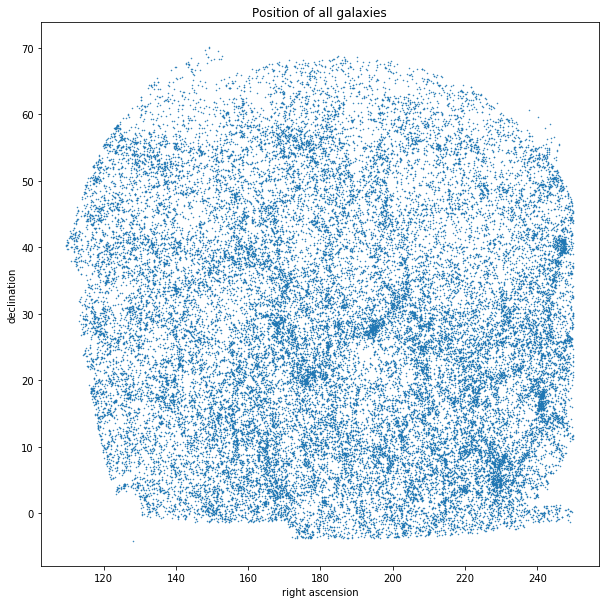

In [9]:
# (4) (4 points: 3 point for the basic plot, 
# 1 point for labeling) Answer:
'''This code plots the distribution of all galaxies in the sky'''

plt.figure(figsize=(10, 10)) #display in 10 by 10 grid
plt.scatter(all_gals['ra'], all_gals['dec'], s=1, marker = ".") #ploting positions of all galaxies using scatter()
plt.xlabel("right ascension") #labeling the x-axis
plt.ylabel("declination")#labeling the y-axis
plt.title("Position of all galaxies") #adding the title


<font color='green'>Great work! (4/4)</font>

#(5) (1 point) Answer:
* ``` The galaxies are not uniformly distributed in the sky. This is because the number of galaxies appear to be densely distributed in some positions such as at RA 230 and Dec 5 and sparsely distributed in others for example, RA 140 and Dec 70. Again, galaxies are not found in some positions mostly below dec 0 and 70. Generally, galaxies are concentrated beween RA 120-240 and Dec 0-70. Through this, I can point out that galaxies are not uniformly distributed in the sky. 
```

<font color='green'>Nice job! (1/1)</font>

### Exercise: 

Using the np.where() command, select galaxies in two narrow redshift slices:
- slice 1: 0.02 < z < 0.03 (green)
- slice 2: 0.03 < z < 0.04 (orange)

Make the same plot as above, but only using the galaxies in each slice using the suggested colour scheme (make one plot for each slice). Finally, make a third plot with galaxies from both redshift slices. Add axis labels, a title and an legend to each plot. 

In [10]:
#(6) (12 points total: 3 points for each of the basic plots, 
# 1 point in each for labeling and a good color scheme.) 
# Answer (which will probably be in 3 separate cells):
slice1 = np.where((all_gals['z'] > 0.02) & ( all_gals['z'] < 0.03))[0] #assigning slice1 to redshfits > 0.02 and <0.03
slice2 = np.where((all_gals['z'] > 0.03) & ( all_gals['z'] < 0.04))[0]#assigning slice2 to redshfits > 0.03 and <0.04

slice1ra = all_gals.loc[slice1]['ra'] #assigning slice1ra to ra with redshfits > 0.02 and <0.03
slice2ra = all_gals.loc[slice2]['ra']#assigning slice2ra to ra with redshfits > 0.03 and < 0.04

slice1dec = all_gals.loc[slice1]['dec']#assigning slice1dec to dec with redshfits > 0.02 and < 0.03
slice2dec= all_gals.loc[slice2]['dec']#assigning slice2dec to dec with redshfits > 0.03 and < 0.04

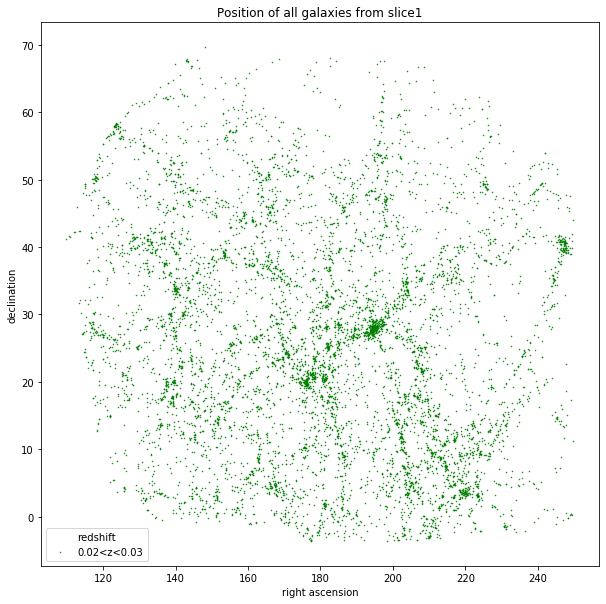

In [11]:
"""This codes plot and label positions of all galaxies with redshift >0.02 and < 0.03"""


plt.figure(figsize=(10, 10)) #display in 10 by 10 grid
plt.scatter(slice1ra, slice1dec, s=1, marker = ".", c = "green", label ="0.02<z<0.03") #ploting positions of all galaxies of 0.02 <z <0.03 using scatter()
plt.xlabel("right ascension") #labeling the x-axis
plt.ylabel("declination")    #labeling the y-axis
plt.title("Position of all galaxies from slice1") #adding the title
plt.legend(loc="lower left", title="redshift")#adding the legends to the lower left

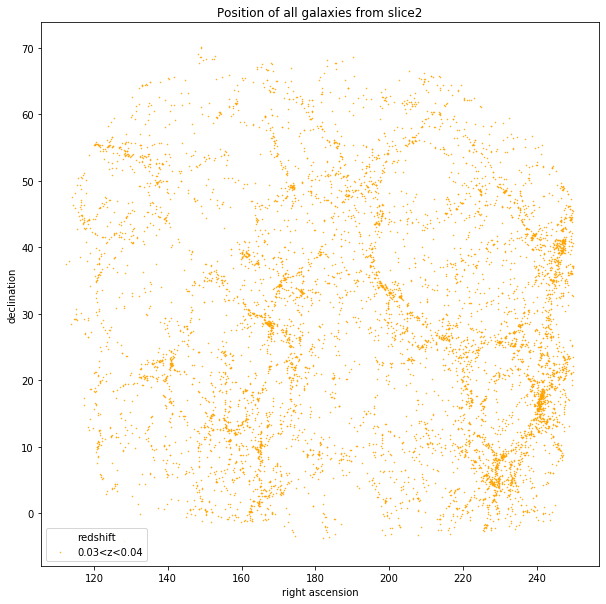

In [12]:
"""This codes plot and label positions of all galaxies with redshift >0.03 and < 0.04"""


plt.figure(figsize=(10, 10)) #display in 10 by 10 grid
plt.scatter(slice2ra, slice2dec, s=1, marker = ".", c = "orange", label ="0.03<z<0.04") #ploting positions of all galaxies of 0.03 <z <0.04 using scatter()
plt.xlabel("right ascension") #labeling the x-axis
plt.ylabel("declination") #labeling the y-axis
plt.title("Position of all galaxies from slice2") #adding the title
plt.legend(loc="lower left", title="redshift") #adding the legends to the lower left

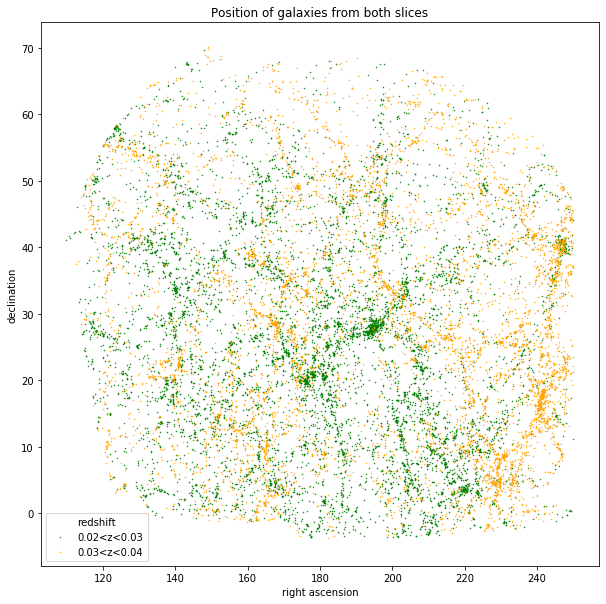

In [13]:
"""This codes plot and label positions of all galaxies from both slice 1 and 2"""

plt.figure(figsize=(10, 10))
plt.scatter(slice1ra, slice1dec, s=1, marker = ".", c = "green", label ="0.02<z<0.03")
plt.scatter(slice2ra, slice2dec, s=1, marker = ".", c = "orange", label ="0.03<z<0.04")
plt.xlabel("right ascension")
plt.ylabel("declination")
plt.title("Position of galaxies from both slices")
plt.legend(loc="lower left", title="redshift")

<font color='green'>Nice job! (12/12)</font>

### Exercise:

Do you see more structure in the distribution of galaxies in each slice, when compared to your first plot that included all galaxies?  (1 point)

What can you tell about the structure you see in the two different redshift slices? (1 point)

Why couldn't you see it in your first plot? (1 point)

#(7) Answer (to all 3 questions):
* ``` Yes, I see more structure in each slice compared to my first plot where some positions that were occupied by galaxies in the first plot are empty or scarce for each slice. However, the shape structure of each slice is not very much different from my first plot. Galaxies with a redshift > 0.02 and < 0.03, slice1 with green colour, appear to be more distributed at the center that is from RA 170- 210 and Dec 15-30. On the hand, Galaxies with a redshift > 0.03 and < 0.04, slice2 with orange colour, appear to be more distributed from RA 220-250 and Dec 5-45. This means that some galaxies with the same redshift are more distributed at certain positions in the sky and less distributed in others meaning that redshift affects the position of galaxies in the sky. This could not be identified while using the first plot since all the galaxies were plotted using the same colour. Also the redshift range for the first plot was large, 0.02-0.5, and since there is a higher number of galaxies within this range, it was difficult to identify.```

<font color='green'>Nice job! (3/3)</font>

## Galaxy colours

You will see in lectures that the optical colours of galaxies are related to the age of their stars - red galaxies hold older stars, whereas blue galaxies tend to have younger stars. In practice, we can quantify "colour" in Astronomy as _the difference in magnitude in two different bands_.

In this set of exercises **we will focus on the first slice in redshift** (call it sl, which is very narrow, meaning that all galaxies have a similar redshift. I.e., if galaxies in this redshift slice have different colours, it ought to be because their spectra and stellar composition are different, and not because some are redshifted due to the expansion of the Universe. 

Plot a histogram of u-g color (really just column "u" minus column "g") of the galaxies in the slice  0.02 < z < 0.03. Don't forget to label your axes and title your plot!


Text(0, 0.5, 'Number of galaxies')

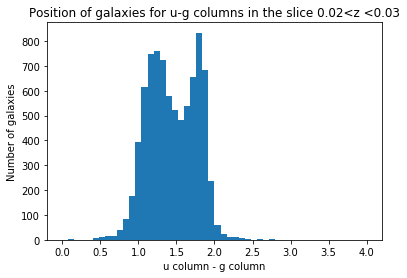

In [14]:
#(8)  (4 points, 3 points for plot, 1 for labels) Answer:
"""This code plots a histogram of columns "u" minus "g" of slice 1"""

slice1=np.where((all_gals['z'] > 0.02) & ( all_gals['z'] < 0.03))[0]
subtraction = all_gals.loc[slice1]['u'] -all_gals.loc[slice1]['g'] #"u" minus "g" columns with slice1 redshifts 
plt.hist(subtraction, bins=50, range=(0, 4)) #ploting a histogram with bins
plt.title("Position of galaxies for u-g columns in the slice 0.02<z <0.03")
plt.xlabel("u column - g column")
plt.ylabel("Number of galaxies")

<font color='green'>Nice job! (4/4)</font>

**np.percentile()** (https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) allows you to quickly return the percentile of a distribution of points. For example, to find the median (50th percentile) u-g colour of your galaxy population you can write:

In [15]:
median_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 50)
print(median_umg)

1.435010000000002


i.e., 50% of the galaxies in your sample have u-g colours that are lower than median_umg (i.e., they are bluer than the median), and 50% have  colours that are larger (i.e., they are redder than the median). If I wanted to choose only the 10% reddest galaxies I could do:

In [16]:
high_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 90)

very_red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > high_umg))
high_umg

1.8633460000000013

### Exercise:

Use np.percentile() to choose the 25% reddest and 25% bluest galaxies in u-g. Then plot their positions on the sky. Do both types of galaxies trace the large-scale structure in a similar way? What can you say about which galaxies preferentially sit on denser parts of the Universe, and which sit on less dense regions? For this exercise it is recommended that you make two plots (one for the red galaxies, and one for the blue), but that you put them side by side to help you compare.


Text(0, 0.5, 'declination')

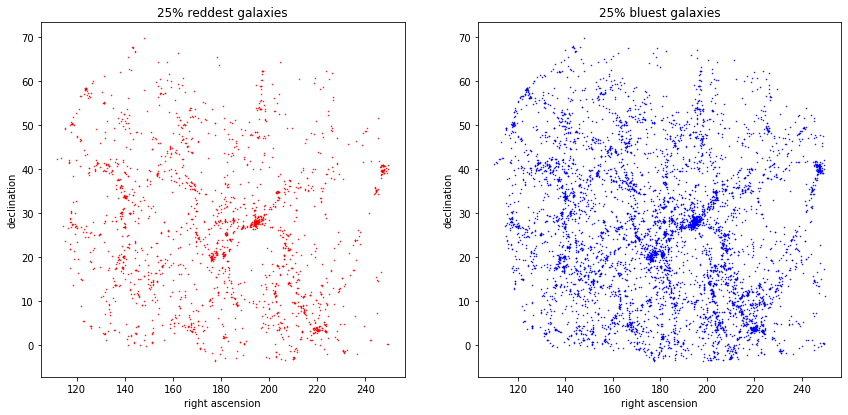

In [17]:
#(9) 8 points total for all of this, 2 points for getting the 
# 25% cutoffs right, 3 points for making each plot and labeling it. You
# should feel free to use multiple cells. Answer:

""""This code label plots for all 25% reddest and 25% bluest galaxies 
       of columns u-g with redshfit >0.02 and <0.03 """""

quater_reddest = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 75) #25% redest galaxies

quater_red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > quater_reddest)) #galaxies of z > 0.02 and <0.03 above 25% redest galaxies mark

quater_bluest = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 25) #25% bluest galaxies

quater_blue_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > quater_bluest)) #galaxies of z > 0.02 and <0.03 above 25% bluest galaxies mark


quater_red_ra = all_gals.loc[quater_red_galaxies]['ra']
quater_red_dec = all_gals.loc[quater_red_galaxies]['dec']

quater_blue_ra = all_gals.loc[quater_blue_galaxies]['ra']
quater_blue_dec = all_gals.loc[quater_blue_galaxies]['dec']

plt.figure(figsize=(30, 30))
plt.subplot(4, 4, 1)
plt.scatter(quater_red_ra, quater_red_dec, s=1, marker =".", c="red")
plt.title("25% reddest galaxies")
plt.xlabel("right ascension")
plt.ylabel("declination")

plt.subplot(4, 4, 2)
plt.scatter(quater_blue_ra, quater_blue_dec, s=1, marker=".", c="blue")
plt.title("25% bluest galaxies")
plt.xlabel("right ascension")
plt.ylabel("declination")

<font color='purple'>Nice job, but for the quarter blue galaxies, it should be less than, not greater than.(7/8)</font>

* ```First, both of this galaxies appear to have similar structures and they trace the large-scale structure in a similar ways. The 25% bluest galaxies preferentially sit in the denser parts of the universe since the number of galaxies at this positions appear to be high. In contrast, the 25% reddest galaxies preferentially sit on the scarce parts of the universe displayed by scarce number of galaxies at this positions.```

By now you will have started developing an understanding of how galaxies in general are spacially distributed in the Universe and the shape of the cosmic web, and how galaxies' position on the cosmic web and their environment is related to their colour. Next, we will look at the **shape** of galaxies.

## Galaxy morphology

Galaxy morphology studies the shapes of galaxies. 

Here, we do a more systematic exploration of how galaxy shapes are related to other properties.

The next cell provides a bit of code that selects 16 **random** galaxies from your dataframe, and shows you their optical images. 

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


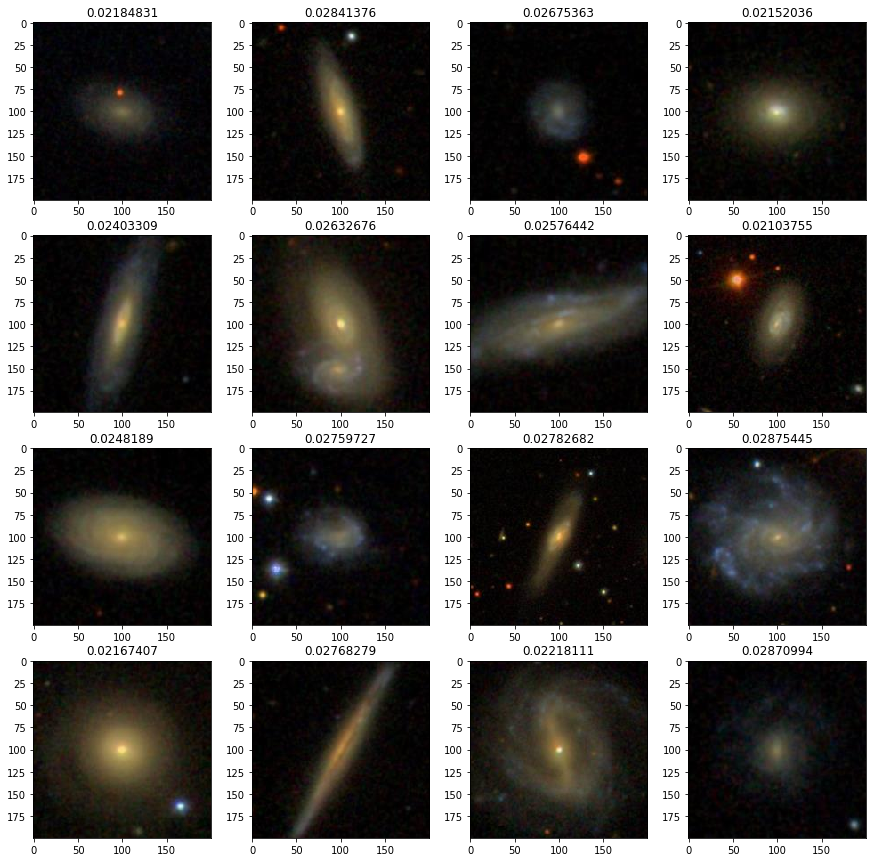

In [18]:
#plot a random subset of 16 galaxies
# set thumbnail parameters

width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1


#let's do any pre-selection of the galaxies here.
#In this case, let us only look at the galaxies in a thin redshift slice
my_galaxies = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]

i = 0
nGalaxies = 16 #Total number of galaxies to plot
ind = np.random.randint(0,len(my_galaxies), nGalaxies) #randomly selected rows
count=0
for i in ind:           # iterate through the randomly selected rows in the DataFrame
    count=count+1
    print('Getting image '+str(count)+' of '+str(nGalaxies)+'...')
    if (count == nGalaxies):
        print('Plotting images...')
    # This appears to set the scale of the images it gets
    scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width
    img = SkyServer.getJpegImgCutout(ra=all_gals.loc[my_galaxies[i]]['ra'], dec=all_gals.loc[my_galaxies[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14')
    plt.subplot(4,4,subPlotNum) # Figures out where to put the new plot
    subPlotNum += 1
    plt.imshow(img)                               # show images in grid
    plt.title(all_gals.loc[my_galaxies[i]]['z'])  # Adds a title!   

### Exercise:
Compute the fraction of galaxies you'd classify as having disks, and the fraction of galaxies you'd classify as being smooth ellipsoids. If you want to improve your statistics, you can rerun the cell above and you will get 16 different galaxies every time...

#(10) (1 point) Answer:
* ```Disks = 7/16```
* ```Ellipsoids= 9/16```

<font color='green'>Nice job! (1/1)</font>

### Exercise:
Now using the code from the example above, do the same thing but taking 16 random galaxies that are **red**, according to your earlier definition of red and blue. Once again, classify the galaxies as disks or ellipticals. **Note, to change the color, you only need to change the line that defines my_galaxies.**  In addition, comment any line of code that doesn't have a comment on it. The comment should explain what that line is for.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


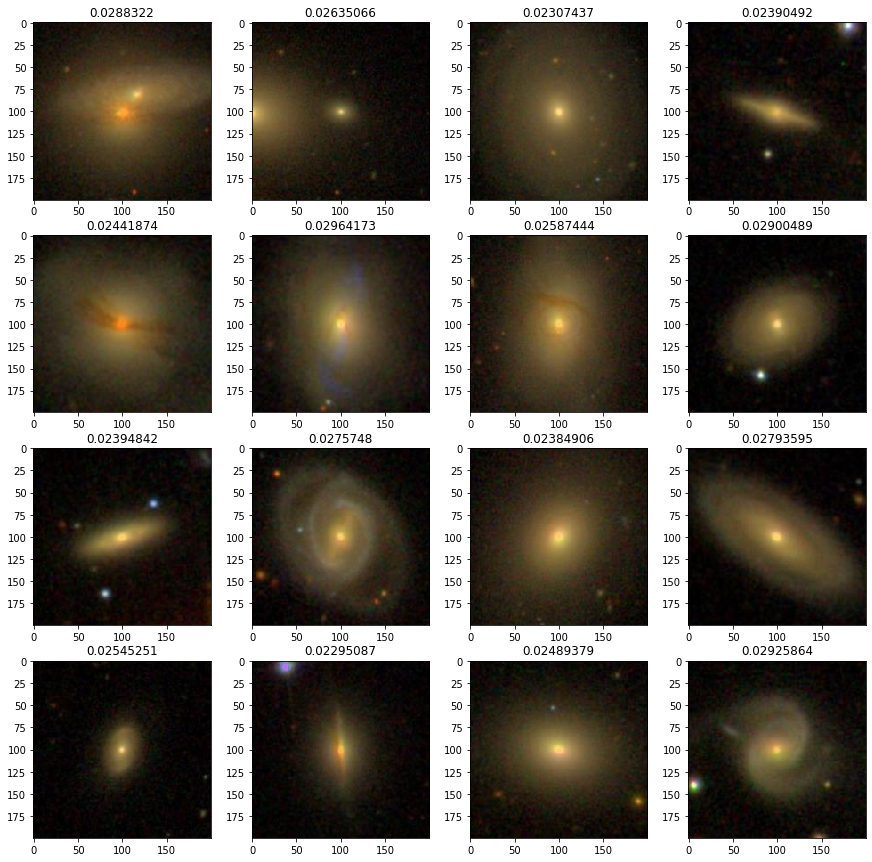

In [19]:
#(11) 7 points total
# 2 for getting the RED part right
# 3 for the comments.
# 2 for getting the plots to come out right. 
# Answer: 
"""
This code plot a random subset of 16 galaxies with redshfit ranging from 0.02 to 0.03
that are 25% reddest in colour
"""

width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1      #creating a subPlotNum variable and assigning it to 1



red_cut_off = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 75) #25% redest galaxies in u-g columns

red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > red_cut_off))[0] #reddest galaxies above 75% of redshift > 0.02 and <0.03

i = 0          #assign a variable i to 0
nGalaxies = 16 #Total number of galaxies to plot
ind = np.random.randint(0,len(red_galaxies), nGalaxies) #randomly selected rows
count=0                  #assign a variable count to 0
for i in ind:           # iterate through the randomly selected rows in the DataFrame
    count=count+1       #add one to every additional galaxy in the loop
    print('Getting image '+str(count)+' of '+str(nGalaxies)+'...') #print a statement and the number of a random galaxy in the loop out of the total 16.
    if (count == nGalaxies):        #create a condition within the loop
        print('Plotting images...') #print a statement after the condition is met
        
    scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width  #set scale of the images it gets
    img = SkyServer.getJpegImgCutout(ra=all_gals.loc[red_galaxies[i]]['ra'], dec=all_gals.loc[red_galaxies[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14') #locate the position of image in the sky
    plt.subplot(4,4,subPlotNum) # Figures out where to put the new plot
    subPlotNum += 1             #add one to each additional subPlotNum
    plt.imshow(img)                               # show images in grid
    plt.title(all_gals.loc[red_galaxies[i]]['z'])  # Adds a title!   

<font color='green'>Nice job! (7/7)</font>

How does requesting red galaxies change the shape of the galaxies?

#(12)  (1 point) 
* ```Requesting the red galaxies returns a set of galaxies that are mainly elliptical(smooth) in shape.```

* ```Ellipticals = 16/16```
* ```Disks = 0/16```

<font color='green'>Nice job! (1/1)</font>

### Exercise:

Repeat the above exercise, now with blue galaxies. Repeat your classification exercise.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


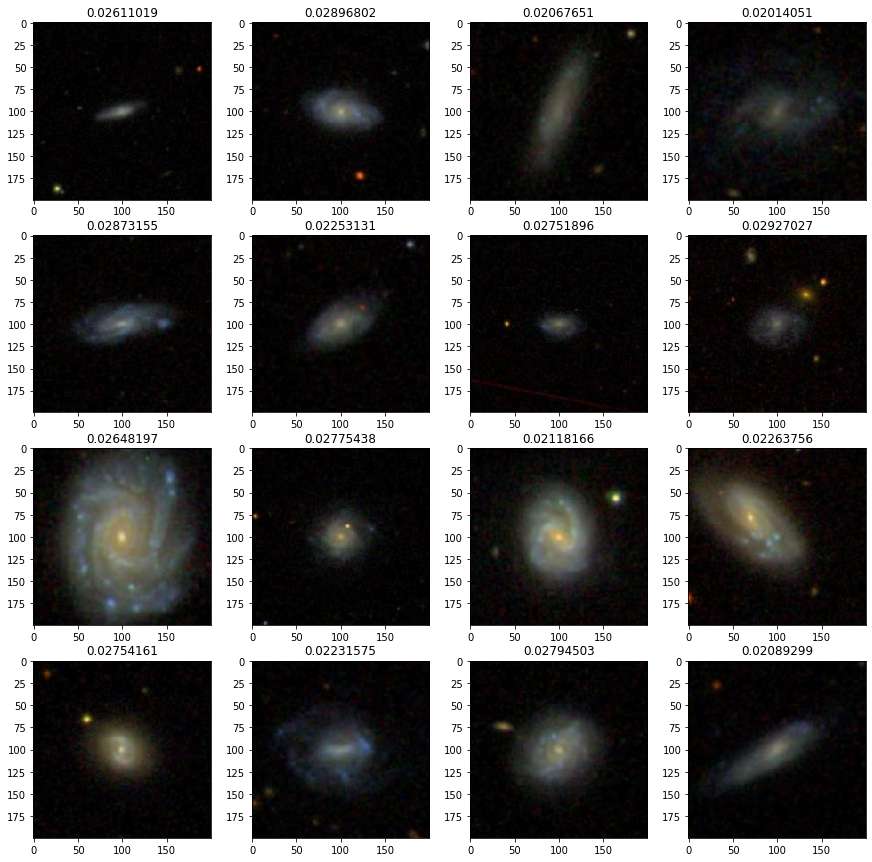

In [20]:
#(13) 11 points, same as above
"""
This code plot a random subset of 16 galaxies with redshfit ranging from 0.02 to 0.03 
that are 25% bluest in colour 
"""

width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1         #creating a subPlotNum variable and assigning it to 1


blue_cut_off = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 25) #25% bluest galaxies in u-g columns

blue_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] < blue_cut_off))[0] # bluest galaxies below 25% of redshift > 0.02 and <0.03 

i = 0             #assign a variable i to 0
nGalaxies = 16    #Total number of galaxies to plot
ind = np.random.randint(0,len(blue_galaxies), nGalaxies) #randomly selected rows
count=0                 #assign a variable count to 0
for i in ind:           # iterate through the randomly selected rows in the DataFrame
    count=count+1       #add one to every additional galaxy in the loop
    print('Getting image '+str(count)+' of '+str(nGalaxies)+'...') #print a statement and the number of a random galaxy in the loop out of the total 16.
    if (count == nGalaxies):        #create a condition within the loop
        print('Plotting images...') #print a statement after the condition is met
    
    scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width #set scale of the images it gets
    img = SkyServer.getJpegImgCutout(ra=all_gals.loc[blue_galaxies[i]]['ra'], dec=all_gals.loc[blue_galaxies[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14') #locate the position of an image in the sky
    plt.subplot(4,4,subPlotNum) # Figures out where to put the new plot
    subPlotNum += 1             #add one to each additional subPlotNum 
    plt.imshow(img)                               # show images in grid
    plt.title(all_gals.loc[blue_galaxies[i]]['z'])  # Adds a title!   

<font color='green'>Nice job! (7/7)</font>

* ```ELLIPTICALS =0/16```
* ```Disks =16/16```

### Exercise:

From the above exercise, what can you say - if anything - about the relationship between colour and morphology?

#(14) (2 points) 
* ``` From the two plots, I have notice that there is a relationship between color and morphology. Galaxies of the same color appear to be having similar shape. This is because the 25% reddest galaxies plotted are ellipticals(ellipsoid shape) while the 25% bluest galaxies are spirals.```

<font color='green'>Nice job! (2/2)</font>

## Morphology and environment

Finally, we will explore the **relationship between morphology and environment**. It is extraordinarily difficult to write a computer programme that determines whether a galaxy has spiral structure or is smooth. To this day, the human eye does better than the most sophisticated algorithms (the reason behind projects such as Galaxy Zoo - https://www.galaxyzoo.org). We will use a very simple proxy for morphology, which is good enough for our purposes: the sersic index. The sersic index tells us how rapidly the light profile of a galaxy is falling from the center, and essentially classifies galaxies' light profiles as being very centrally concentrated (like ellipticals), or as being flatter (like spirals). 

The cell below repeats our initial SQL query, but now it also returns the sersic profile, called sersic_n, and we are already limiting the redshift range to be between 0.02 and 0.03.

In [21]:
query="""
SELECT p.objId, p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid, n.sersic_n
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
   JOIN nsatlas AS n ON n.mjd = s.mjd and n.fiberID = s.fiberID and n.plate = s.plate
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.03
  and p.g < 17
"""
all_gals = CasJobs.executeQuery(query, "dr14")
print(" Query returns " + str(len(all_gals))+ " galaxies")

 Query returns 7869 galaxies


Make a histogram of the values of the sersic index in your sample. Label your histogram with axes and a title. Make sure the number of bins is reasonable.

In [22]:
#(15) (4 points) Answer:
sersicIndex=all_gals['sersic_n']
plt.hist(sersicIndex, bins=50)
plt.title("Sersic index histogram")
plt.xlabel("Sersic index")
plt.ylabel("number of galaxies")

Text(0, 0.5, 'number of galaxies')

<font color='green'>Nice job! (4/4)</font>

### Exercise:

Look at the morphologies of high and low sersic index galaxies, like you did for blue and red. In other words, make a set of 16 plots of high sersic index galaxies, and then a set of 16 plots of low sersic index galaxies. Let us test that idea that galaxies with a very high sersic index (n > 4) are ellipticals , and those with a very low sersic index (n < 2) are spirals. After you've looked at both those sets of plots (you should show them all below) answer this question: In your opinion, how good is this number at identifying morphology?

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


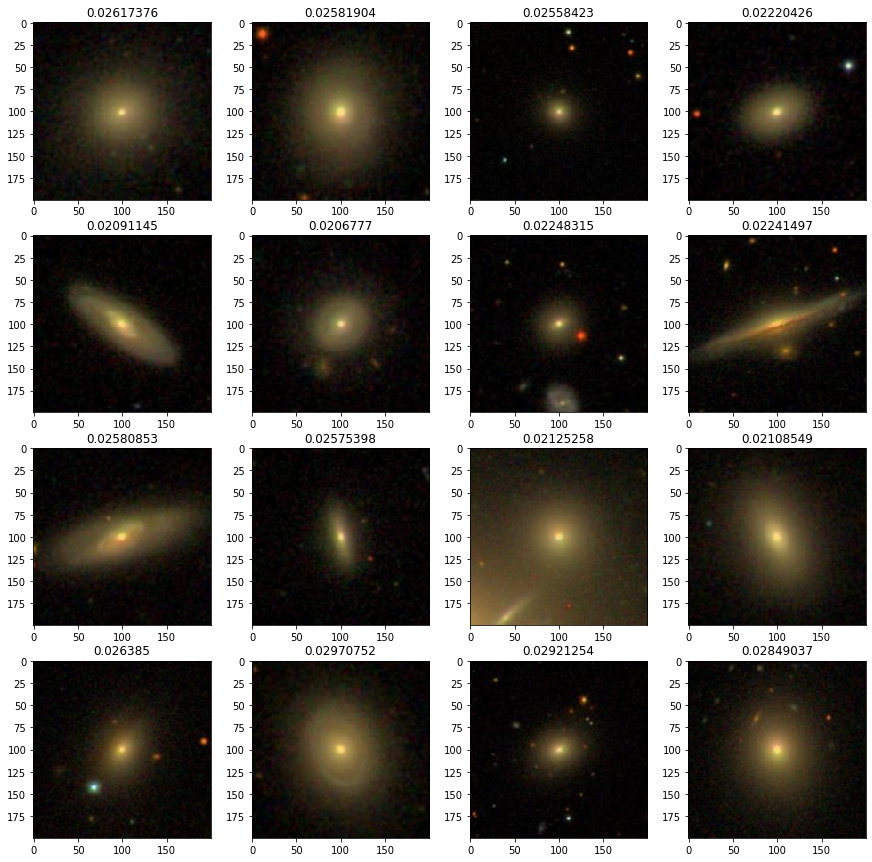

In [23]:
#(16) 4 points for ellipticals. Answer:

"""
This code plot a random subset of 16 galaxies with redshfit ranging from 0.02 to 0.03 
with sersic index greater than 4 
"""

width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1  #creating a subPlotNum variable and assigning it to 1




ellipticals = np.where(all_gals["sersic_n"] > 4 )[0] #galaxies with spiral index greater than 4

i = 0
nGalaxies = 16 #Total number of galaxies to plot
ind = np.random.randint(0,len(ellipticals), nGalaxies) #randomly selected rows
count=0
for i in ind:           # iterate through the randomly selected rows in the DataFrame
    count=count+1
    print('Getting image '+str(count)+' of '+str(nGalaxies)+'...') #print a statement and the number of a random galaxy in the loop out of the total 16.
    if (count == nGalaxies): #create a condition within the loop
        print('Plotting images...') #print a statement after the condition is met

    scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width #set scale of the images it gets
    img = SkyServer.getJpegImgCutout(ra=all_gals.loc[ellipticals[i]]['ra'], dec=all_gals.loc[ellipticals[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14')#locate the position of an image in the sky
    plt.subplot(4,4,subPlotNum) # Figures out where to put the new plot
    subPlotNum += 1
    plt.imshow(img)                               # show images in grid
    plt.title(all_gals.loc[ellipticals[i]]['z'])  # Adds a title!   

<font color='green'>Nice job! (4/4)</font>

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


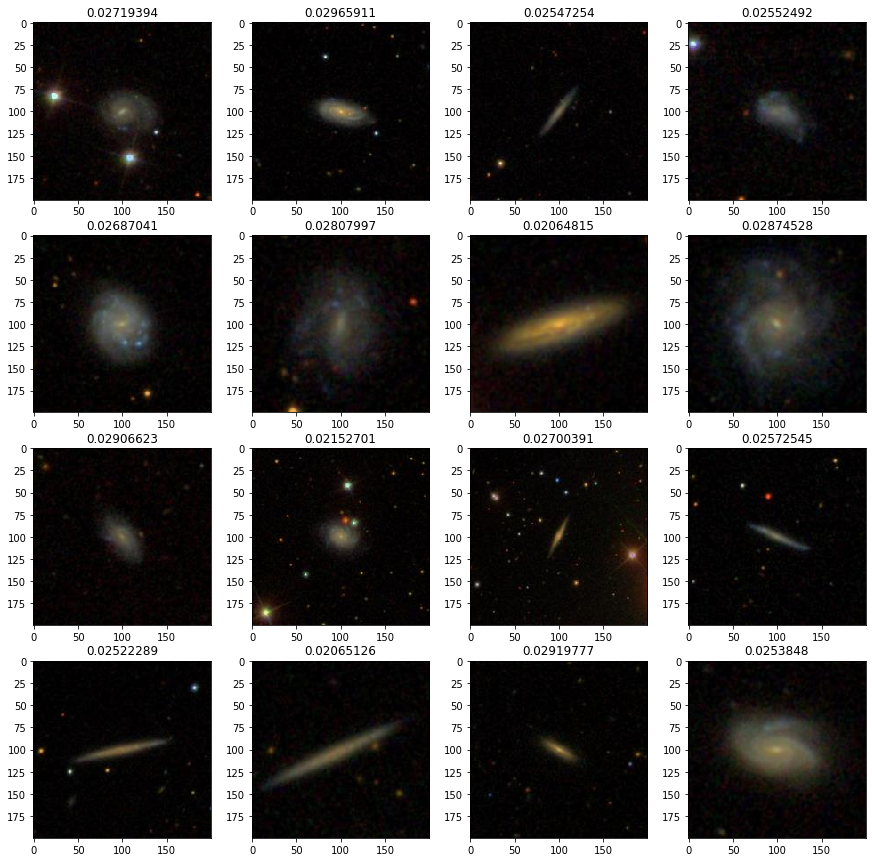

In [24]:
#(17) 4 points for spirals. Answer:
"""
This code plot a random subset of 16 galaxies with redshfit ranging from 0.02 to 0.03 
with sersic index less than 2 
"""

width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1  #creating a subPlotNum variable and assigning it to 1



spiral = np.where(all_gals["sersic_n"] < 2 )[0] #galaxies with spiral index less than 2

i = 0
nGalaxies = 16 #Total number of galaxies to plot
ind = np.random.randint(0,len(spiral), nGalaxies) #randomly selected rows
count=0
for i in ind:           # iterate through the randomly selected rows in the DataFrame
    count=count+1
    print('Getting image '+str(count)+' of '+str(nGalaxies)+'...') #print a statement and the number of a random galaxy in the loop out of the total 16.
    if (count == nGalaxies): #create a condition within the loop
        print('Plotting images...') #print a statement after the condition is met
    
    scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width #set scale of the images it gets
    img = SkyServer.getJpegImgCutout(ra=all_gals.loc[spiral[i]]['ra'], dec=all_gals.loc[spiral[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14')#locate the position of an image in the sky
    plt.subplot(4,4,subPlotNum) # Figures out where to put the new plot
    subPlotNum += 1
    plt.imshow(img)                               # show images in grid
    plt.title(all_gals.loc[spiral[i]]['z'])  # Adds a title!   

<font color='green'>Nice job! (4/4)</font>

In [25]:
#(18) 1 point for your thoughtful opinion about how 
# good this sersic index is at identifying morphology.  (I swear 
# there's not a right answer here, because I really did ask for
# your opinion, but I want it to be thoughful and informed.)
# Answer: 

**# 18 Answer**
* ```Personally, I think the sersic index is 98% accurate at identifying morphology. This is because most of the ellipticals galaxies, sersic index > 4, are red while the spiral galaxies, sersic index < 2, are blue. Therefore, sersic index illustrates that elements with similar shape, spiral or ellipticals, have the same colour. ```

<font color='green'>Nice job! (1/1)</font>

Write a summary (4-6 sentences) of the gains you made in your astronomical knowledge doing this lab. 

#(19) 3 points
* ```Doing this lab, expecially 0.02<z0.03 and 0.03<z0.04, I have learnt that galaxies with the same redshifts appear to be distributed at the same positions in the sky. This means that galaxies with different redshifts are positioned differently in the sky. Through sersic index, I learnt that galaxies are either spiral or ellipticals in shape. Also these shapes are related to the color of the galaxies such that those with ellipticals shape are red while the spiral ones are blue. Further, using the 25% bluest and reddest concept, I learnt that 25% bluest galaxies are many than 25% reddest galaxies. This illustrates that bluest galaxies are located in the denser parts of the universe while reddest galaxies are distributed in sparse parts of the universe meaning that more galaxies are blue. Further, by plotting all these galaxies, I have learnt that galaxies have a similar structure, cosmic web, in the sky.```

<font color='green'>Nice job! (3/3)</font>

Write a summary (4-6 sentences) of the gains you made in your programming skills while doing this lab.

#(20) 3 points
* ``` First, I learnt to use the SELECT part of the SQL query to determined the columns of a table. For example, if an item is named p.item1 or s.tem1 in the SELECT part of the query, python returns the table columns as item1. Also, I learnt about using 'loc' to slice a table (finding a given set of rows or columns). For example, all_gals.loc[0:5, 'u':'i'] returns the first 6 rows, from 0 to 5, of the columns from 'u' to 'i' of all_gals variable. Again, I gained the knowledge of using 'np.where' and 'loc' together to manipulate arrays in different columns of a table. For example, when finding elements of the 'ra' column where redshift is > 0.02, the 'z' column, the first code used is slice1=np.where(all_gals['z']>0.02)[0] and the second code used is all_gals.loc[slice1]['ra']. Besides, I learnt about plotting data using plt.scatters and adding legends to the plots. Further, I also knew how to find the percentile distribution of data using np.percentile. ```



<font color='green'>Nice job! (3/3)</font>

<font color='green'>Fantastic work on this lab! Your final grade is (72/73). Please let Andrea, Suzanne, or any of the TAs know if oyu have any questions about the lab, comments that were made on your lab, or about material which has been covered in class.</font>

**Congratulations, that is the end of the Lab!** Make sure you've **run all the code cells, filled in all the text answers and that your plots are all showing without error**. 